In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
import torchvision
from torchvision import datasets, models, transforms

In [3]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import pandas as pd
import json
import cv2
from PIL import ImageDraw, ImageFont
from collections import namedtuple, OrderedDict

In [4]:
from session import *
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
torch.cuda.is_available(), torch.cuda.get_device_name(0), torch.backends.cudnn.enabled
torch.backends.cudnn.benchmark=True

In [7]:
DATA_PATH = Path('C:/fastai/courses/dl2/data/road_damage_dataset')

In [8]:
MULTICLASS_CSV_PATH = DATA_PATH/'mc.csv'

In [9]:
im_size = 256

In [10]:
train_tfms = TransformList([
        RandomScale(im_size, 1.1),
        RandomCrop(im_size),
        RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = TransformList([
        Scale(im_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [11]:
batch_size = 8
data = ImageData.from_csv(DATA_PATH, MULTICLASS_CSV_PATH, batch_size, train_tfms, val_tfms)
num_classes = 8

In [12]:
# next(iter(data['valid']))

[
 ( 0 , 0 ,.,.) = 
  -1.5117e+00 -1.4654e+00 -1.0086e+00  ...  -2.0156e+00 -2.0705e+00 -1.9377e+00
  -1.7961e+00 -2.0117e+00 -1.8465e+00  ...  -2.0214e+00 -2.0565e+00 -1.6959e+00
  -1.8263e+00 -6.9939e-01 -6.6646e-01  ...  -2.0778e+00 -2.0689e+00 -1.7229e+00
                  ...                   ⋱                   ...                
  -1.0352e+00 -9.7123e-01 -9.9343e-01  ...  -8.7509e-01 -9.0603e-01 -9.3691e-01
  -1.0214e+00 -9.1091e-01 -1.0898e+00  ...  -5.9513e-01 -8.5523e-01 -8.5281e-01
  -1.0532e+00 -8.3838e-01 -1.2406e+00  ...  -8.2876e-01 -6.2507e-01 -9.2418e-01
 
 ( 0 , 1 ,.,.) = 
  -1.1947e+00 -1.2186e+00 -8.3691e-01  ...  -1.8961e+00 -1.9652e+00 -1.8459e+00
  -1.5968e+00 -1.8401e+00 -1.7180e+00  ...  -1.8796e+00 -1.9300e+00 -1.5668e+00
  -1.6871e+00 -5.3482e-01 -5.4150e-01  ...  -1.9312e+00 -1.9480e+00 -1.5853e+00
                  ...                   ⋱                   ...                
  -5.0037e-01 -4.7852e-01 -5.1803e-01  ...  -7.2434e-01 -7.6131e-01 -7.9288e-01


In [12]:
model_ft = models.resnet18(pretrained=True)
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Dropout(p=.2),
    nn.Linear(num_ftrs, num_classes),
    nn.Sigmoid()
)

In [13]:
criterion = nn.BCELoss()
optim_fn = optim.Adam

In [14]:
sess = Session(model_ft, criterion, optim_fn, [*[1e-3] * 9, 1e-2])

In [15]:
sess.freeze() 

In [ ]:
lr_find(sess, data['train'], start_lr=1e-7)

In [ ]:
sess.set_lr(3e-4)

In [18]:
accuracy = NHotAccuracy(num_classes)
validator = Validator(data['valid'], accuracy)
lr_scheduler = Cyclical(len(data['train']) * 24)
schedule = TrainingSchedule(data['train'], [validator, lr_scheduler])

In [25]:
# validator.run(sess)

In [ ]:
sess.train(schedule, 24)

Training Loss: 0.5179624956861002  Validaton Loss: 0.4156085894150688 Validation Accuracy: 0.8192427385892116


Training Loss: 0.5736094954604037  Validaton Loss: 0.5470268232528929 Validation Accuracy: 0.7762793914246197


Training Loss: 0.6401722181328229  Validaton Loss: 0.4494893181538351 Validation Accuracy: 0.8055843706777317


Training Loss: 0.6342242334874947  Validaton Loss: 0.5435196390455359 Validation Accuracy: 0.7475795297372061


Training Loss: 0.651687793952164  Validaton Loss: 0.4625587859918798 Validation Accuracy: 0.7796507607192255


Training Loss: 0.613895442529775  Validaton Loss: 0.46313228366450815 Validation Accuracy: 0.7921853388658368


Training Loss: 0.5823226289624163  Validaton Loss: 0.4687081113725612 Validation Accuracy: 0.7988416320885201


Training Loss: 0.5689221421305449  Validaton Loss: 0.4377796075733206 Validation Accuracy: 0.8188969571230982


Training Loss: 0.5796492007065862  Validaton Loss: 0.4845966711990731 Validation Accuracy: 0.77783540802213


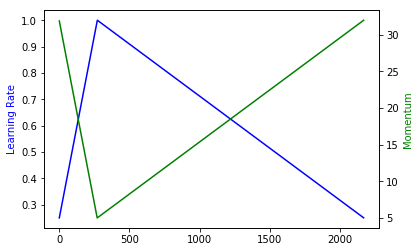

In [27]:
lr_scheduler.plot()

In [28]:
for detail in accuracy.confusion:
    print(detail)

{'correct_pos': 23, 'correct_neg': 1074, 'false_pos': 21, 'false_neg': 328}
{'correct_pos': 335, 'correct_neg': 689, 'false_pos': 207, 'false_neg': 215}
{'correct_pos': 0, 'correct_neg': 1350, 'false_pos': 0, 'false_neg': 96}
{'correct_pos': 14, 'correct_neg': 1286, 'false_pos': 64, 'false_neg': 82}
{'correct_pos': 70, 'correct_neg': 1050, 'false_pos': 15, 'false_neg': 311}
{'correct_pos': 3, 'correct_neg': 1396, 'false_pos': 4, 'false_neg': 43}
{'correct_pos': 110, 'correct_neg': 1302, 'false_pos': 16, 'false_neg': 18}
{'correct_pos': 333, 'correct_neg': 876, 'false_pos': 96, 'false_neg': 141}


In [29]:
print("Precision: ", accuracy.precision()) 
print("Recall: ", accuracy.recall())
print("F-Measure: ", accuracy.FMeasure())

Precision:  [0.5227272727272727, 0.6180811808118081, 0, 0.1794871794871795, 0.8235294117647058, 0.42857142857142855, 0.873015873015873, 0.7762237762237763]
Recall:  [0.06552706552706553, 0.6090909090909091, 0, 0.14583333333333334, 0.1837270341207349, 0.06521739130434782, 0.859375, 0.7025316455696202]
F-Measure:  [0.11645569620253164, 0.6135531135531135, 0, 0.16091954022988506, 0.30042918454935624, 0.11320754716981131, 0.8661417322834646, 0.7375415282392026]


In [ ]:
sess.save('TrainLayer1')

In [ ]:
sess.load('TrainLayer1')

In [ ]:
sess.unfreeze()

In [ ]:
lr_find(sess, data['train'], 
        start_lr=[*[1e-6 / 1000] * 5, *[1e-6 / 100] * 4, 1e-6], 
        end_lr=[*[10 / 1000] * 5, *[10 / 100] * 4, 10])

In [ ]:
sess.set_lr([*[1e-4 / 1000] * 5, *[1e-4 / 100] * 4, 1e-4])

In [ ]:
accuracy = NHotAccuracy(num_classes)
validator = Validator(data['valid'], accuracy)
lr_scheduler = CosAnneal(len(data['train']), T_mult=2)
schedule = TrainingSchedule(data['train'], [validator, lr_scheduler])

sess.train(schedule, 7)

In [ ]:
for detail in accuracy.confusion:
    print(detail)

In [ ]:
print("Precision: ", accuracy.precision()) 
print("Recall: ", accuracy.recall())
print("F-Measure: ", accuracy.FMeasure())

In [ ]:
lr_scheduler.plot()

In [ ]:
sess.save('FullTrain')

In [ ]:
sess.load('FullTrain')

In [ ]:
sess.train(schedule, 8)

In [ ]:
sess.save('FullTrain2')

In [ ]:
sess.load('FullTrain2')

In [ ]:
print("Precision: ", accuracy.precision()) 
print("Recall: ", accuracy.recall())
print("F-Measure: ", accuracy.FMeasure())

In [ ]:
for detail in accuracy.confusion:
    print(detail)